In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../../data/4-fitting')
outdir = Path('.')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'Fitting', False: 'Cross-Validation'
})
results_df = results_df.sort_values(
    ['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair']).reset_index(drop=True)
results_df['Sparsity Coefficient'] = results_df['lambda'].astype(str)

results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,genus,comparison,Sparsity Coefficient
0,0,1,0.0,A,A,"A, A",1,5023.0,0.864485,NaN,pro,Fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5023.0,0.925260,0.002083,pro,Cross-Validation,0.0
2,0,1,0.0,A,C,"A, C",1,5023.0,0.937960,0.000951,pro,Cross-Validation,0.0
3,0,1,0.0,B,A,"B, A",1,5023.0,1.120335,NaN,pro,Cross-Validation,0.0
4,0,1,0.0,B,B,"B, B",1,5023.0,0.845432,NaN,pro,Fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,99,15,10.0,B,B,"B, B",15,158.0,0.776414,NaN,syn,Fitting,10.0
12596,99,15,10.0,B,C,"B, C",15,158.0,0.966722,0.482680,syn,Cross-Validation,10.0
12597,99,15,10.0,C,A,"C, A",15,73.8,0.893775,NaN,syn,Cross-Validation,10.0
12598,99,15,10.0,C,B,"C, B",15,73.8,0.903613,NaN,syn,Cross-Validation,10.0


# Plot cross-validation data

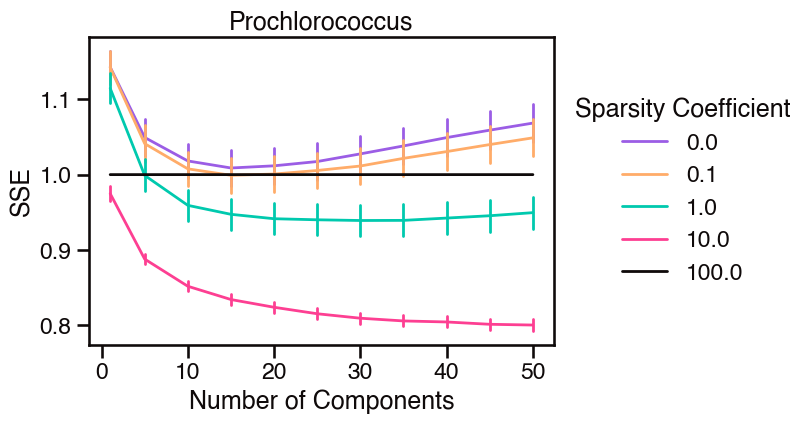

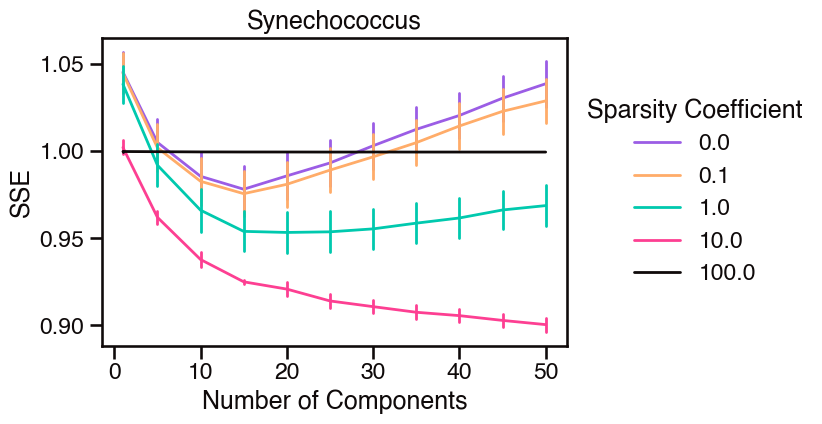

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    );

    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('Number of Components');
    plt.ylabel('SSE')
    plt.legend(title='Sparsity Coefficient', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')


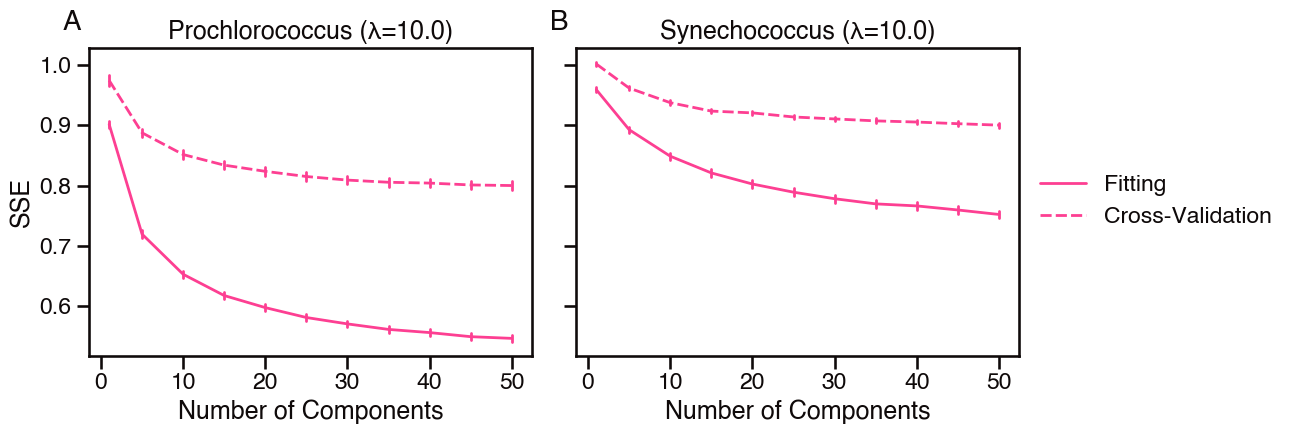

In [5]:
# look at relative_sse vs rank

# define data
bootstraps = np.arange(10)
lamb = 10.0

# set up subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'wspace': 0.1})
annotations = {0: 'A', 1: 'B'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

for i, genus in enumerate(['pro', 'syn']):
    # define data
    plot_df = results_df[results_df['genus'] == genus]
    plot_df = plot_df[plot_df['lambda'] == lamb]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 400, 800])]
    plot_df = plot_df[plot_df['bootstrap_id'].isin(bootstraps)]

    # plot figure
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=sns.color_palette()[3], 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axes[i], 
        legend=i
    );

    # labels and such
    axes[i].annotate(annotations[i], **annot_kws)
    axes[i].set(title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], lamb), 
                xlabel='Number of Components', ylabel='SSE')
    if i:
        axes[i].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    
    # save figure
    fig.savefig(outdir / 'high-rank-sse.png', bbox_inches='tight')
    

In [13]:
# find minimum SSE

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
# summary_df = summary_df[summary_df['lambda'].isin([0.0])]
summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
        mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
        relative_sse=('relative_sse', 'mean'), 
        fms_cv=('fms_cv', 'mean'), 
        bootstraps=('fms_cv', 'count')
    ).sort_values(
    # ['genus', 'relative_sse'], ascending=True
    ['genus', 'fms_cv'], ascending=[True, False]
).head(50)


mean_gene_sparsity  relative_sse    fms_cv  bootstraps
genus rank lambda                                                        
pro   15   10.0            103.882222      0.833922  0.536553          30
           16.0             46.698667      0.845926  0.534473         300
      10   10.0            134.063333      0.851574  0.523274          30
      15   4.0             309.588889      0.865791  0.520752          30
      10   1.0            1321.346667      0.959148  0.519144          30
      15   2.0             688.922222      0.909324  0.518767          30
           8.0             138.920000      0.836573  0.517147          30
           1.0            1180.813333      0.947214  0.510374          30
      20   10.0             84.431667      0.823623  0.505305          30
      5    1.0            1510.766667      0.998966  0.498820          30
      25   10.0             72.306667      0.815013  0.496878          30
      30   10.0             62.568889      0.809075  0.490153          30
      15   0.1            3025.655556      0.999096  0.480497          30
      10   0.1            3071.940000      1.007684  0.476899          30
      20   1.0            1105.230000      0.941355  0.473350          30
      35   10.0             55.569524      0.805459  0.469609          30
      5    0.1            3044.800000      1.041206  0.468780          30
           10.0            208.913333      0.887720  0.457776          30
      40   10.0             50.137500      0.804093  0.446515          30
      45   10.0             45.674074      0.801001  0.444966          30
      25   1.0            1046.324000      0.939937  0.444535          30
      30   1.0             989.468889      0.938998  0.440159          30
      35   1.0             939.672381      0.939172  0.430416          30
      50   10.0             41.714667      0.800007  0.423978          30
      20   0.1            2865.610000      1.000769  0.419612          30
      5    0.0            5023.000000      1.049390  0.418019          30
      40   1.0             891.626667      0.942223  0.409323          30
      45   1.0             857.240000      0.945338  0.400428          30
      25   0.1            2747.017333      1.005501  0.394250          30
      15   32.0              7.555556      0.925767  0.388390          30
      50   1.0             823.599333      0.949432  0.382130          30
      30   0.1            2665.976667      1.011436  0.376931          30
      35   0.1            2597.840000      1.021637  0.366932          30
      40   0.1            2515.079167      1.030600  0.352476          30
      45   0.1            2448.876296      1.039962  0.335374          30
      50   0.1            2371.963333      1.048904  0.325377          30
      10   0.0            5023.000000      1.018185  0.322322          30
      1    10.0            352.633333      0.974783  0.293998          30
      15   0.0            5023.000000      1.008813  0.288223          30
      45   0.0            5023.000000      1.059102  0.250511          30
      50   0.0            5023.000000      1.068510  0.248490          30
      40   0.0            5023.000000      1.049213  0.246260          30
      20   0.0            5023.000000      1.011702  0.238813          30
      35   0.0            5023.000000      1.038138  0.234593          30
      30   0.0            5023.000000      1.027564  0.232783          30
      25   0.0            5023.000000      1.017389  0.220268          30
      15   64.0              0.462222      0.992918  0.142744          30
      1    1.0            1925.900000      1.114810  0.071919          30
           0.1            3370.466667      1.142555  0.062328          30
           0.0            5023.000000      1.142920  0.034103          30

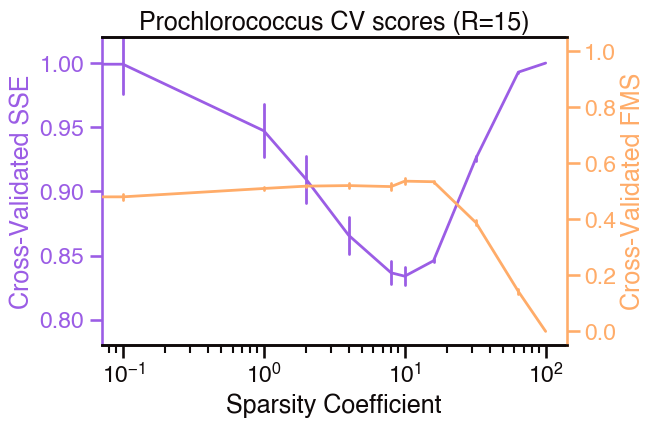

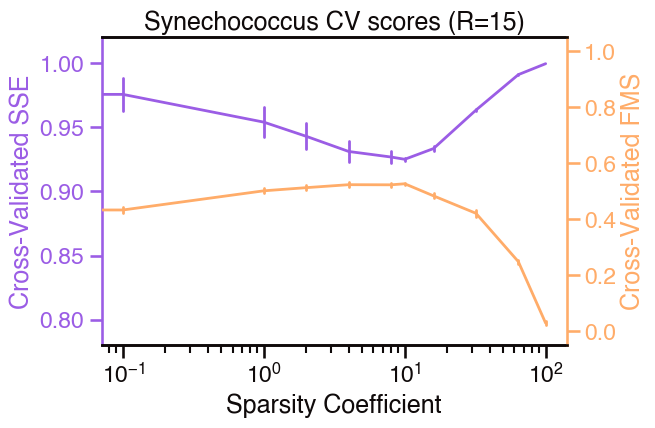

In [7]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 15, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    # plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


# Combined figure

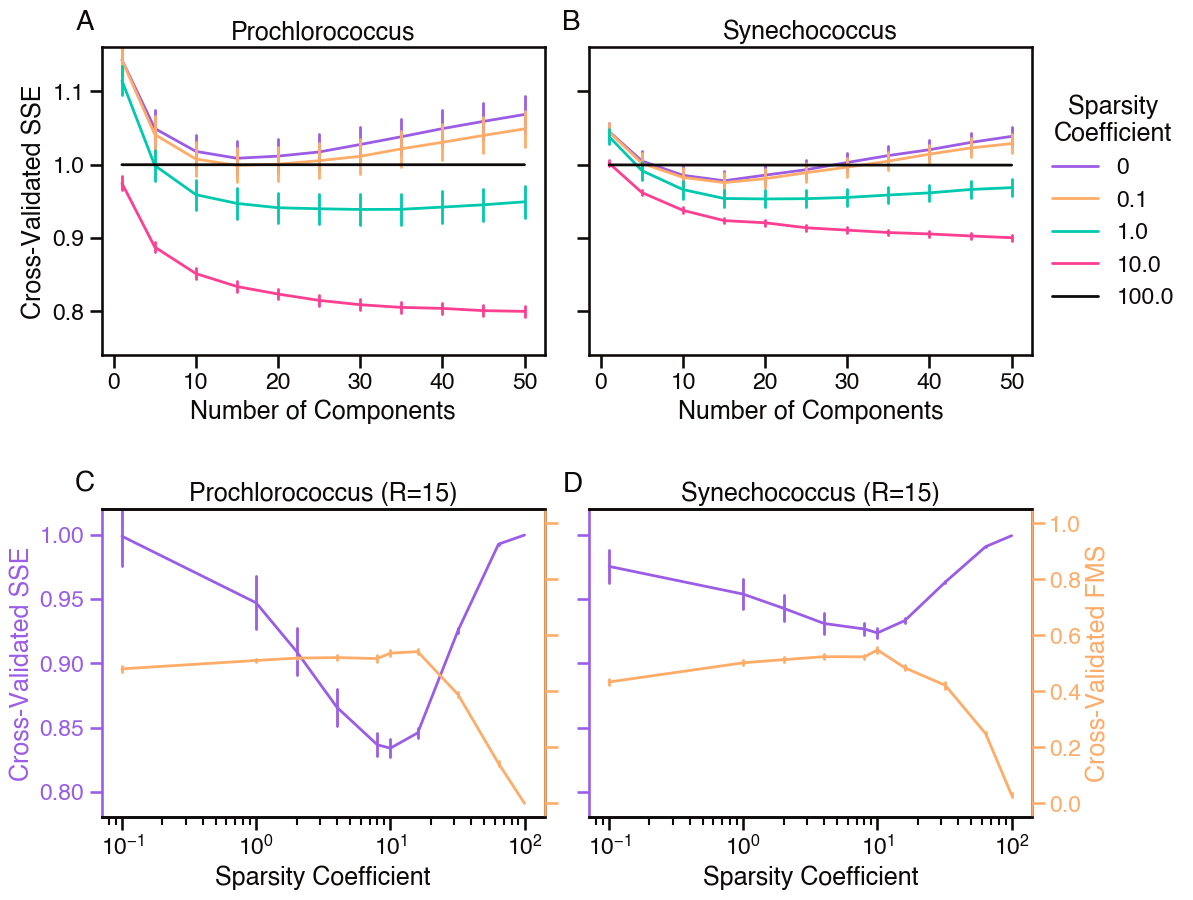

In [8]:
# combined fitting data panels

# define data to plot
plot_bootstraps = np.arange(10)
r_plot_ranks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
r_plot_lambdas = [0, 0.1, 1., 10., 100.]
l_plot_ranks = {'pro': 15, 'syn': 15}
l_plot_lambdas = [0.1, 1., 2., 4., 8., 10., 16., 32., 64., 100.]

# set up subplots
fig, axes = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5}
)
annotations = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

# iterate through cyanobacteria
for i, genus in enumerate(['pro', 'syn']):
    # set up genus data
    data_df = results_df[results_df['genus'] == genus]
    data_df = data_df[data_df['bootstrap_id'].isin(plot_bootstraps)]
    data_df = data_df[data_df['modeled_replicate'] != data_df['comparison_replicate']]
    
    # make SSE vs. rank plot
    for j, lamb in enumerate(r_plot_lambdas):
        plot_df = data_df[data_df['rank'].isin(r_plot_ranks)]
        plot_df = plot_df[plot_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[j], 
            errorbar='se', 
            err_style='bars', 
            data=plot_df,
            ax=axes[0][i], 
            label=lamb, 
            legend=False
    );
    # set lables and such
    axes[0][i].annotate(annotations[i], **annot_kws)
    if i:
        axes[0][i].set(xlabel='Number of Components', ylabel=None, title='Synechococcus', ylim=[0.74, 1.16])
        axes[0][i].tick_params(labelleft=False)
        axes[0][i].legend(title='\t Sparsity\nCoefficient', alignment='center', 
                          loc='center left', bbox_to_anchor=(1, .5));
    else:
        axes[0][i].set(xlabel='Number of Components', ylabel='Cross-Validated SSE', 
                       title='Prochlorococcus', ylim=[0.74, 1.16])
        
    # make FMS & SSE vs. lambda plot
    plot_df = data_df[data_df['lambda'].isin(l_plot_lambdas)]
    plot_df = plot_df[plot_df['rank'] == l_plot_ranks[genus]]
    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axes[1][i], 
        legend=False
    )
    # set lables and such
    axes[1][i].tick_params(axis='y', colors=color)
    axes[1][i].spines['left'].set_color(color)
    if i:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axes[1][i].tick_params(labelleft=False)
    else:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated SSE')
        axes[1][i].yaxis.label.set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axes[1][i])
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    # set lables and such
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)
    axis2.set(title='{} (R={})'.format(
        {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], l_plot_ranks[genus]))
    axis2.annotate(annotations[2+i], **annot_kws)
    if i:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated FMS')
        axis2.yaxis.label.set_color(color)
    else:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axis2.tick_params(labelright=False)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True
    
fig.savefig(outdir / 'pro-syn-model-fitting.png', bbox_inches='tight')


# Other plots

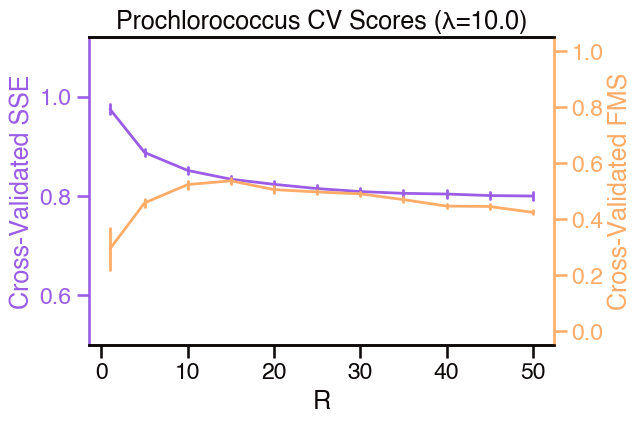

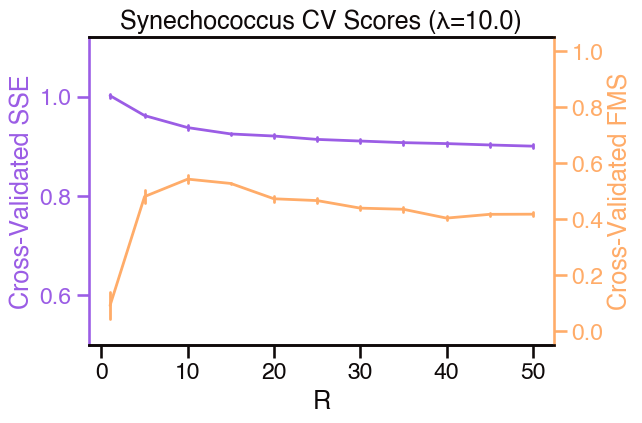

In [9]:
# look at SSE and FMS vs rank

# define data
lamb = 10.0

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV Scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb));
    # plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


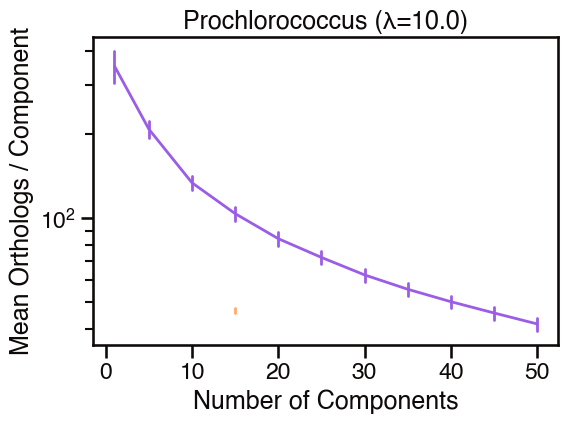

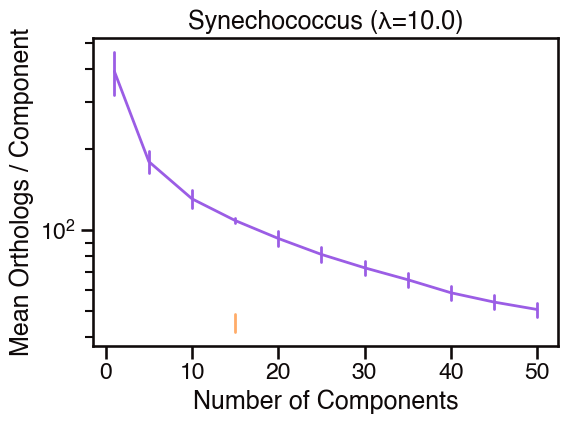

In [10]:
# look at number of nonzero components with rank

# define data
lambs = [10.0, 16.0]
for cyano in ['pro', 'syn']:
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['lambda'].isin(lambs)]
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        legend=False, 
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        xlabel='Number of Components', ylabel='Mean Orthologs / Component', yscale='log', 
        title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb)
    )
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
